<a href="https://colab.research.google.com/github/villasen/colab_notebooks/blob/master/Keras_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Urban dataset download and file structure setup for train, validation, and test

In [10]:
!git clone https://github.com/villasen/small-urban-sound-dataset.git

Cloning into 'small-urban-sound-dataset'...
remote: Enumerating objects: 9719, done.
remote: Counting objects: 100% (9719/9719), done.
remote: Compressing objects: 100% (9324/9324), done.
remote: Total 9719 (delta 398), reused 9713 (delta 394), pack-reused 0
Receiving objects: 100% (9719/9719), 259.08 MiB | 37.24 MiB/s, done.
Resolving deltas: 100% (398/398), done.
Checking out files: 100% (10185/10185), done.


In [0]:
!rm -r /content/small-urban-sound-dataset

In [0]:
!rm -r test_single_file/

In [8]:
!rm -r /content/target_npy_files/

rm: cannot remove '/content/target_npy_files/': No such file or directory


In [12]:
#from preprocess import *
import keras
from keras import layers
from keras import models
from keras import backend as K
from keras import optimizers
from keras import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import numpy as np
import librosa
import tensorflow
import scipy
import os, shutil
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


target_dir = '/content/target_npy_files'
target_model = '/content/target_model/'
#DATA_PATH = "small-urban-sound-dataset/tiny-dataset/"
DATA_PATH = "small-urban-sound-dataset/combined_datasets/"
os.mkdir(target_dir)

test_single_file = 'test_single_file/'
os.mkdir(test_single_file)
!mv small-urban-sound-dataset/combined_datasets/Helicopter/1-172649-A.wav test_single_file


def wav2mfcc(file_path, max_pad_len):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    mfcc = librosa.feature.mfcc(wave, sr=16000, n_mfcc=10, n_fft=640, hop_length=320)
    pad_width = max_pad_len - mfcc.shape[1]
    if pad_width < 0: 
      print(mfcc.shape[1])
      print(pad_width)
      print("error in "+ file_path)
    
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    return mfcc

  
  
def get_labels(path):
    labels = os.listdir(path) 
    label_indices = np.arange(0, len(labels))
    return labels, label_indices, to_categorical(label_indices)  



               
def save_data_to_array(path=DATA_PATH, max_pad_len=51):
    labels, _, _ = get_labels(path)

    for label in labels:
        # Init mfcc vectors
        mfcc_vectors = []

        wavfiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
        for wavfile in wavfiles:
            if label == '_background_noise_' : break
            mfcc = wav2mfcc(wavfile, max_pad_len=max_pad_len)
            
            mfcc_vectors.append(mfcc)
        np.save('/content/target_npy_files/' + label + '.npy', mfcc_vectors)
        print(label)
        print(len(mfcc_vectors))
        

        

def get_train_test(split_ratio=0.9, random_state=42):
    # Get available labels
    labels, indices, _ = get_labels(DATA_PATH)

    # Getting first arrays
    X = np.load('/content/target_npy_files/' + labels[0] + '.npy')
    y = np.zeros(X.shape[0])

    
    # Append all of the dataset into one single array, same goes for y
    for i, label in enumerate(labels[1:]):
        x = np.load('/content/target_npy_files/' + label + '.npy')
        
        X = np.vstack((X, x))
        y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))
        
    assert X.shape[0] == len(y)

    return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)

  
  
  
save_data_to_array(path=DATA_PATH, max_pad_len=51)    
X_train, X_test, y_train, y_test = get_train_test()

X_train = X_train.reshape(X_train.shape[0], 10, 51, 1)
X_test = X_test.reshape(X_test.shape[0], 10, 51, 1)
y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

Using TensorFlow backend.


hen
40
dog_bark
1000
coughing
40
cow
40
pig
40
train
40
street_music
1000
clapping
40
air_conditioner
1000
sea_waves
40
chirping_birds
40
laughing
40
chainsaw
40
siren
929
pouring_water
40
water_drops
40
jackhammer
1000
clock_tick
40
insects
40
thunderstorm
40
cat
40
toilet_flush
40
drilling
1000
wind
40
clock_alarm
40
engine_idling
1000
mouse_click
40
car_horn
40
breathing
40
children_playing
1000
sneezing
40
church_bells
40
washing_machine
40
rain
40
rooster
40
can_opening
40
vacuum_cleaner
40
brushing_teeth
40
snoring
40
Helicopter
39
gun_shot
374
airplane
40
sheep
40
keyboard_typing
40


In [0]:
  
#save_data_to_array(path=DATA_PATH, max_pad_len=51)    
X_train, X_test, y_train, y_test = get_train_test()

X_train = X_train.reshape(X_train.shape[0], 10, 51, 1)
X_test = X_test.reshape(X_test.shape[0], 10, 51, 1)
y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

In [0]:
!rm -r /content/target_npy_files/*.npy

# Building DS-CNN model using Keras framework

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 8731 samples, validate on 971 samples
Epoch 1/200
8731/8731 [==============================] - 7s 792us/step - loss: 3.1998 - acc: 0.1160 - val_loss: 2.8840 - val_acc: 0.1287
Epoch 2/200
8731/8731 [==============================] - 2s 184us/step - loss: 2.6929 - acc: 0.1833 - val_loss: 2.8833 - val_acc: 0.1390
Epoch 3/200
8731/8731 [==============================] - 2s 194us/step - loss: 2.5627 - acc: 0.2180 - val_loss: 2.6976 - val_acc: 0.2019
Epoch 4/200
8731/8731 [==============================] - 2s 187us/step - loss: 2.4785 - acc: 0.2405 - val_loss: 2.5780 - val_acc: 0.2441
Epoch 5/200
8731/8731 [==============================] - 2s 182us/step - loss: 2.3919 - acc: 0.2621 - val_loss: 2.3819 - val_acc: 0.2966
Epoch 6/200
8731/8731 [==========

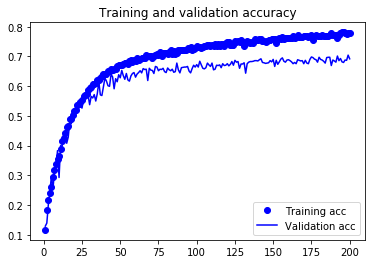

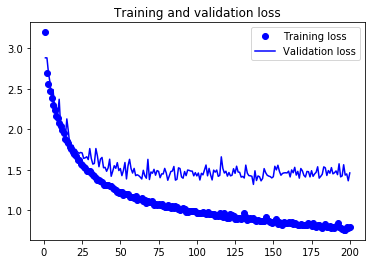

In [13]:
# Creating Keras sequential model
#bn = 1
target_model = '/content/target_model/'
os.mkdir(target_model)
BN=True
model = models.Sequential()

def dscnn_train():
  # 1
      model.add(layers.Conv2D(64, (4,10), strides=(2,2), padding='same', activation='relu', \
                #input_shape=(10, 49, 1)))
                input_shape=(10,51,1)))
      #model.add(layers.Dropout(0.5))
      if BN == True:
          model.add(layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, \
                                                center=True, scale=True, beta_initializer='zeros', \
                                                gamma_initializer='ones', moving_mean_initializer='zeros', \
                                                moving_variance_initializer='ones', beta_regularizer=None, \
                                                gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
      
      #model.add(layers.Dropout(0.5))
      model.add(layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0))
      #model.add(layers.Dropout(0.5))
      # 2
      model.add(layers.SeparableConv2D(64, (3,3), strides=(1,1), data_format='channels_last', padding='same', depth_multiplier=1, activation='relu'))  
      if BN == True:
          model.add(layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, \
                                              center=True, scale=True, beta_initializer='zeros', \
                                              gamma_initializer='ones', moving_mean_initializer='zeros', \
                                              moving_variance_initializer='ones', beta_regularizer=None, \
                                              gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
      #model.add(layers.Dropout(0.5))
      model.add(layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0))
      #model.add(layers.Dropout(0.5))

      model.add(layers.Conv2D(64, (1,1), strides=(1,1), padding='same', use_bias=False))
      if BN == True:
          model.add(layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, \
                                              center=True, scale=True, beta_initializer='zeros', \
                                              gamma_initializer='ones', moving_mean_initializer='zeros', \
                                              moving_variance_initializer='ones', beta_regularizer=None, \
                                              gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
     # model.add(layers.Dropout(0.5))
      model.add(layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0))
     # model.add(layers.Dropout(0.5))
      # 3
      model.add(layers.SeparableConv2D(64, (3,3), strides=(1,1), data_format='channels_last', padding='same', depth_multiplier=1, activation='relu'))
      if BN == True:
          model.add(layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, \
                                              center=True, scale=True, beta_initializer='zeros', \
                                              gamma_initializer='ones', moving_mean_initializer='zeros', \
                                              moving_variance_initializer='ones', beta_regularizer=None, \
                                              gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
      
      #model.add(layers.Dropout(0.5))
      model.add(layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0))
     # model.add(layers.Dropout(0.5))
      
      model.add(layers.Conv2D(64, (1,1), strides=(1,1), padding='same', use_bias=False))
      if BN == True:
          model.add(layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, \
                                              center=True, scale=True, beta_initializer='zeros', \
                                              gamma_initializer='ones', moving_mean_initializer='zeros', \
                                              moving_variance_initializer='ones', beta_regularizer=None, \
                                              gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
      #model.add(layers.Dropout(0.5))
      model.add(layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0))
      model.add(layers.Dropout(0.5))

      # 4
      model.add(layers.SeparableConv2D(64, (3,3), strides=(1,1), data_format='channels_last', padding='same', depth_multiplier=1, activation='relu'))
      if BN == True:
          model.add(layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, \
                                              center=True, scale=True, beta_initializer='zeros', \
                                              gamma_initializer='ones', moving_mean_initializer='zeros', \
                                              moving_variance_initializer='ones', beta_regularizer=None, \
                                              gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
      #model.add(layers.Dropout(0.5))
      model.add(layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0))
      model.add(layers.Dropout(0.5))
      model.add(layers.Conv2D(64, (1,1), strides=(1,1), padding='same', use_bias=False))
      if BN == True:
          model.add(layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, \
                                              center=True, scale=True, beta_initializer='zeros', \
                                              gamma_initializer='ones', moving_mean_initializer='zeros', \
                                              moving_variance_initializer='ones', beta_regularizer=None, \
                                              gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
      model.add(layers.Dropout(0.5))
      model.add(layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0))
      model.add(layers.Dropout(0.5))

      # 5
      model.add(layers.SeparableConv2D(64, (3,3), strides=(1,1), data_format='channels_last', padding='same', depth_multiplier=1, activation='relu'))
      if BN == True:
          model.add(layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, \
                                              center=True, scale=True, beta_initializer='zeros', \
                                              gamma_initializer='ones', moving_mean_initializer='zeros', \
                                              moving_variance_initializer='ones', beta_regularizer=None, \
                                              gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
      #model.add(layers.Dropout(0.5))
      model.add(layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0))
      model.add(layers.Dropout(0.5))
      model.add(layers.Conv2D(64, (1,1), strides=(1,1), padding='same', use_bias=False))
      if BN == True:      
          model.add(layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, \
                                              center=True, scale=True, beta_initializer='zeros', \
                                              gamma_initializer='ones', moving_mean_initializer='zeros', \
                                              moving_variance_initializer='ones', beta_regularizer=None, \
                                              gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
      #model.add(layers.Dropout(0.5))
      model.add(layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0))
      model.add(layers.Dropout(0.5))


      
           
      
# Final layer
      
      #model.add(layers.Dropout(0.5))
      model.add(layers.AveragePooling2D(pool_size=(5, 25), strides=(2,2), padding='valid', data_format=None))
      model.add(layers.Dropout(0.5))
      model.add(layers.Flatten(data_format=None))
     # model.add(layers.Dropout(0.5))
      model.add(layers.Dense(64, activation='relu'))
      model.add(layers.Dropout(0.5))
      #model.add(layers.Dense(12, activation='softmax'))
      model.add(layers.Dense(44, activation='softmax'))
      #model.add(layers.Dropout(0.5))
      # Compilation step to choose loss function, optimizer and metric
      # Configuring the learning process
      model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
      #model.fit()
      history = model.fit(X_train, y_train_hot, batch_size=100, epochs=200, verbose=1, validation_data=(X_test, y_test_hot))
      
      #plt.plot(history.history['acc'])
      #Restarts layer sequence number 
      #K.clear_session()

      acc = history.history['acc']
      val_acc = history.history['val_acc']
      loss = history.history['loss']
      val_loss = history.history['val_loss']
      epochs = range(1, len(acc) + 1)
      
      plt.plot(epochs, acc, 'bo', label='Training acc')
      plt.plot(epochs, val_acc, 'b', label='Validation acc')
      plt.title('Training and validation accuracy')
      plt.legend()

      plt.figure()

      plt.plot(epochs, loss, 'bo', label='Training loss')
      plt.plot(epochs,val_loss, 'b', label='Validation loss')
      plt.title('Training and validation loss')
      plt.legend()
      plt.show()
      
      
      model.save('/content/target_model/urban_sound.h5')
  
dscnn_train()  

### Testing the model with an unseen file

In [0]:

prediction = model.predict(np.array(tk.texts_to_sequences(text)))
print(prediction)

###Save Model

---



In [0]:
model.save('urban_sound.h5')

In [0]:
model.summary()

In [0]:
from keras import backend as K
# This line must be executed before loading Keras model.
K.set_learning_phase(0)

In [15]:
from keras.models import load_model
model = load_model('target_model/urban_sound.h5')
print(model.outputs)
# [<tf.Tensor 'dense_2/Softmax:0' shape=(?, 10) dtype=float32>]
print(model.inputs)
# [<tf.Tensor 'conv2d_1_input:0' shape=(?, 28, 28, 1) dtype=float32>]

[<tf.Tensor 'dense_2_1/Softmax:0' shape=(?, 44) dtype=float32>]
[<tf.Tensor 'conv2d_1_input_1:0' shape=(?, 10, 51, 1) dtype=float32>]


In [0]:
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph


In [18]:
import tensorflow as tf
frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])

Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 438 variables.
INFO:tensorflow:Converted 438 variables to const ops.


In [19]:
tf.train.write_graph(frozen_graph, "model", "urban_sound_model.pb", as_text=False)

'model/tf_model.pb'

In [0]:

plt.plot(history.history['acc'])

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

In [0]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs,val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()



##Alternate folder train and test structure

In [0]:
sample = wav2mfcc('/content/small-urban-sound-dataset/tiny-dataset/crackling_fire/1-17150-A.wav')

#X_train = X_train.reshape(X_train.shape[0], 10, 51, 1)


In [0]:
print(sample.shape)

In [0]:
sample_reshape = sample.reshape(sample(10,51,1))

In [0]:
print(get_labels() [0] [np.argmax(model.predict(sample_reshape))])

In [0]:
model.summary()

In [0]:

base_directory ='/content/target_dataset/'
os.mkdir(base_directory)
train_dir = os.path.join(base_directory, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_directory, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_directory, 'test')
os.mkdir(test_dir)


In [0]:
original_dataset_dir = '/content/Sound-Datasets/combined_datasets/'

In [0]:
train_gunshot_dir = os.path.join(train_dir, 'gun_shot')
os.mkdir(train_gunshot_dir)
train_dogbark_dir = os.path.join(train_dir, 'dog_bark')
os.mkdir(train_dogbark_dir)

validation_gunshot_dir = os.path.join(validation_dir, 'gun_shot')
os.mkdir(validation_gunshot_dir)
validation_dogbark_dir = os.path.join(validation_dir, 'dog_bark')
os.mkdir(validation_dogbark_dir)

test_gunshot_dir = os.path.join(test_dir, 'gun_shot')
os.mkdir(test_gunshot_dir)
test_dogbark_dir = os.path.join(test_dir, 'dog_bark')
os.mkdir(test_dogbark_dir)


In [0]:
fnames_dog = os.listdir('/content/Sound-Datasets/combined_datasets/dog_bark')
fnames_gun = os.listdir('/content/Sound-Datasets/combined_datasets/gun_shot')
fnames = os.listdir('/content/Sound-Datasets/combined_datasets/dog_bark')

In [0]:
#print(fnames)
size = len(fnames)
train_percentage = 0.8
validation_percentage = 0.1
test_percentage = 0.1
print('train percentage = %f' %train_percentage)
train_size = int(round(size * (train_percentage)))
validation_size = int(round(size * (validation_percentage)))
test_size = int(round(size * (test_percentage)))
print(size)
print('train_size = %i' %train_size)
print('validation_size = %i' %validation_size)
print('test_size = %i' %test_size)
total = train_size + validation_size + test_size
print(total)

In [0]:


#os.chdir('/content/combined_datasets/dog_bark')
train_list=[]
validation_list=[]
test_list=[]

train_list = fnames[0:train_size]
validation_list = fnames[train_size:train_size+validation_size]
test_list = fnames[train_size+validation_size:total]


for train in train_list:
  src_train = os.path.join(original_dataset_dir+'dog_bark', train )
  dst_train = os.path.join('/content/target_dataset/train/dog_bark', train)
  shutil.copyfile(src_train, dst_train)

for validation in validation_list:
  src_validation = os.path.join(original_dataset_dir+'dog_bark', validation)
  dst_validation = os.path.join('/content/target_dataset/validation/dog_bark', validation)
  shutil.copyfile(src_validation, dst_validation)
  
for test in test_list:
  src_test = os.path.join(original_dataset_dir+'dog_bark', test)
  dst_test = os.path.join('/content/target_dataset/test/dog_bark', test)
  shutil.copyfile(src_test, dst_test)
  
        
  

In [0]:
fnames_train = os.listdir('/content/target_dataset/train/dog_bark')
print(len(fnames_train))
fnames_val = os.listdir('/content/target_dataset/validation/dog_bark')
print(len(fnames_val))
fnames_test = os.listdir('/content/target_dataset/test/dog_bark')
print(len(fnames_test))


In [0]:
validation_gunshot_dir = os.path.join(validation_dir, 'gun_shot')
os.mkdir(validation_gunshot_dir)
validation_dogbark_dir = os.path.join(validation_dir, 'dog_bark')
os.mkdir(validation_dogbark_dir)

In [0]:
test_gunshot_dir = os.path.join(test_dir, 'gun_shot')
os.mkdir(test_gunshot_dir)
test_dogbark_dir = os.path.join(test_dir, 'dog_bark')
os.mkdir(test_dogbark_dir)

###Preparing for google speech dataset


In [0]:
data_url='http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz'
os.makedirs(dest_directory)
filename = data_url.split('/')[-1]
filepath = os.path.join(dest_directory, filename)

print(filename)
print(filepath)
 
def _progress(count, block_size, total_size):
    sys.stdout.write('\r>> Downloading %s %.1f%%' % \
            (filename, float(count * block_size) / float(total_size) * 100.0)) 
    sys.stdout.flush()

urban_dataset_dir = '/content/combined_datasets/' 


In [0]:
filepath, _ = urllib.request.urlretrieve(data_url, filepath, _progress)
statinfo = os.stat(filepath)
tf.logging.info('Successfully downloaded %s (%d bytes)', filename, statinfo.st_size)
tarfile.open(filepath, 'r:gz').extractall(dest_directory)